In [3]:
import numpy as np
import networkx as nx

In [4]:
def compute_depth_complexity(G):
    """
    Average longest-path depth over all nodes.
    """
    if len(G) == 0:
        return 0.0

    # Compute longest path lengths from all roots
    # Use dynamic programming since graph is DAG
    depth = {}

    # Topological order guarantees correctness
    for node in nx.topological_sort(G):
        preds = list(G.predecessors(node))
        if not preds:
            depth[node] = 0
        else:
            depth[node] = 1 + max(depth[p] for p in preds)

    return np.mean(list(depth.values()))

In [5]:
def compute_branching_variance(G):
    """
    Variance of out-degrees.
    """
    if len(G) == 0:
        return 0.0

    out_degrees = [G.out_degree(n) for n in G.nodes()]
    return np.var(out_degrees)

In [6]:
def compute_degree_entropy(G):
    """
    Shannon entropy of out-degree distribution.
    """
    if len(G) == 0:
        return 0.0

    out_degrees = [G.out_degree(n) for n in G.nodes()]
    values, counts = np.unique(out_degrees, return_counts=True)
    probs = counts / counts.sum()

    return -np.sum(probs * np.log(probs + 1e-12))

In [7]:
def compute_path_proliferation(G):
    """
    Average number of descendants per node.
    """
    if len(G) == 0:
        return 0.0

    descendants_counts = []
    for node in G.nodes():
        descendants_counts.append(len(nx.descendants(G, node)))

    return np.mean(descendants_counts)

In [8]:
def compute_tro_structural_complexity(G,
                                      alpha=1.0,
                                      beta=1.0,
                                      gamma=1.0,
                                      delta=1.0):
    """
    Composite TRO structural complexity.
    """
    C_depth = compute_depth_complexity(G)
    C_branch = compute_branching_variance(G)
    C_entropy = compute_degree_entropy(G)
    C_path = compute_path_proliferation(G)

    return (alpha * C_depth +
            beta * C_branch +
            gamma * C_entropy +
            delta * C_path)

In [9]:
def compute_tro_complexity_minimal(G):
    return (compute_depth_complexity(G) +
            compute_branching_variance(G))

In [10]:
# ============================
# PHASE 1 — METRIC SANITY CHECK
# ============================

import networkx as nx
import numpy as np

def print_metrics(G, name):
    print(f"\n{name}")
    print("Nodes:", len(G.nodes()))
    print("Edges:", len(G.edges()))
    print("Depth:", compute_depth_complexity(G))
    print("Branch variance:", compute_branching_variance(G))
    print("Degree entropy:", compute_degree_entropy(G))
    print("Path proliferation:", compute_path_proliferation(G))


# --- A) Pure Chain ---
G_chain = nx.DiGraph()
for i in range(10):
    G_chain.add_node(i)
for i in range(9):
    G_chain.add_edge(i, i+1)

# --- B) Pure Star ---
G_star = nx.DiGraph()
for i in range(10):
    G_star.add_node(i)
for i in range(1,10):
    G_star.add_edge(0, i)

# --- C) Balanced Binary Tree ---
G_tree = nx.DiGraph()
for i in range(7):
    G_tree.add_node(i)
edges = [(0,1),(0,2),(1,3),(1,4),(2,5),(2,6)]
G_tree.add_edges_from(edges)

print_metrics(G_chain, "Chain")
print_metrics(G_star, "Star")
print_metrics(G_tree, "Balanced Tree")


Chain
Nodes: 10
Edges: 9
Depth: 4.5
Branch variance: 0.09
Degree entropy: 0.32508297338944825
Path proliferation: 4.5

Star
Nodes: 10
Edges: 9
Depth: 0.9
Branch variance: 7.290000000000001
Degree entropy: 0.32508297338944825
Path proliferation: 0.9

Balanced Tree
Nodes: 7
Edges: 6
Depth: 1.4285714285714286
Branch variance: 0.9795918367346939
Degree entropy: 0.6829081046984717
Path proliferation: 1.4285714285714286


In [11]:
import numpy as np
import networkx as nx
import random

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)

In [12]:
def propose_random_edge(G: nx.DiGraph, rng: np.random.Generator):
    """Propose a random directed edge (u -> v) with u != v."""
    nodes = list(G.nodes())
    u = int(rng.choice(nodes))
    v = int(rng.choice(nodes))
    while v == u:
        v = int(rng.choice(nodes))
    return (u, v)

def is_admissible_dag_edge(G: nx.DiGraph, u: int, v: int) -> bool:
    """Admissible if edge doesn't already exist and doesn't create a cycle."""
    if G.has_edge(u, v):
        return False
    # Adding u->v creates a cycle iff there is already a path v -> u
    return not nx.has_path(G, v, u)

def weight_edge(G: nx.DiGraph, u: int, v: int, coupling: float) -> float:
    """
    A coupling-sensitive weight. You can replace this with your TRO master equation.

    Here we penalize attachments to high out-degree sources and high in-degree targets
    as a simple structural proxy:
        W = exp(-coupling * (outdeg(u) + indeg(v)) / scale)
    """
    scale = 10.0
    x = (G.out_degree(u) + G.in_degree(v)) / scale
    return float(np.exp(-coupling * x))

def run_simulation(steps: int, coupling: float, seed: int, n0: int = 50, K: int = 30):
    """
    Option B: per step, generate K candidate edges, sample ONE by weights,
    accept if admissible else do nothing.

    Returns dict with graph_history and accepted history.
    """
    seed_everything(seed)
    rng = np.random.default_rng(seed)

    G = nx.DiGraph()
    G.add_nodes_from(range(n0))

    graph_history = []
    accepted_hist = []

    for t in range(steps):
        # Generate candidate edges
        candidates = [propose_random_edge(G, rng) for _ in range(K)]
        weights = np.array([weight_edge(G, u, v, coupling) for (u, v) in candidates], dtype=float)
        wsum = weights.sum()

        # If all weights are ~0, fallback to uniform
        if not np.isfinite(wsum) or wsum <= 0:
            idx = int(rng.integers(0, K))
        else:
            probs = weights / wsum
            idx = int(rng.choice(np.arange(K), p=probs))

        u, v = candidates[idx]

        # Option B: accept or reject, no resampling
        if is_admissible_dag_edge(G, u, v):
            G.add_edge(u, v)
            accepted = 1
        else:
            accepted = 0

        accepted_hist.append(accepted)
        graph_history.append(G.copy())

    return {
        "graph_history": graph_history,
        "accepted": np.array(accepted_hist, dtype=int),
    }

In [13]:
# ============================
# PHASE 2 — SINGLE STRUCTURAL RUN
# ============================

steps = 2000
coupling = 0
seed = 42

results = run_simulation(steps=steps, coupling=coupling, seed=seed)

depth_hist = []
branch_hist = []
entropy_hist = []
path_hist = []
edge_hist = []

for G in results["graph_history"]:
    depth_hist.append(compute_depth_complexity(G))
    branch_hist.append(compute_branching_variance(G))
    entropy_hist.append(compute_degree_entropy(G))
    path_hist.append(compute_path_proliferation(G))
    edge_hist.append(len(G.edges()))

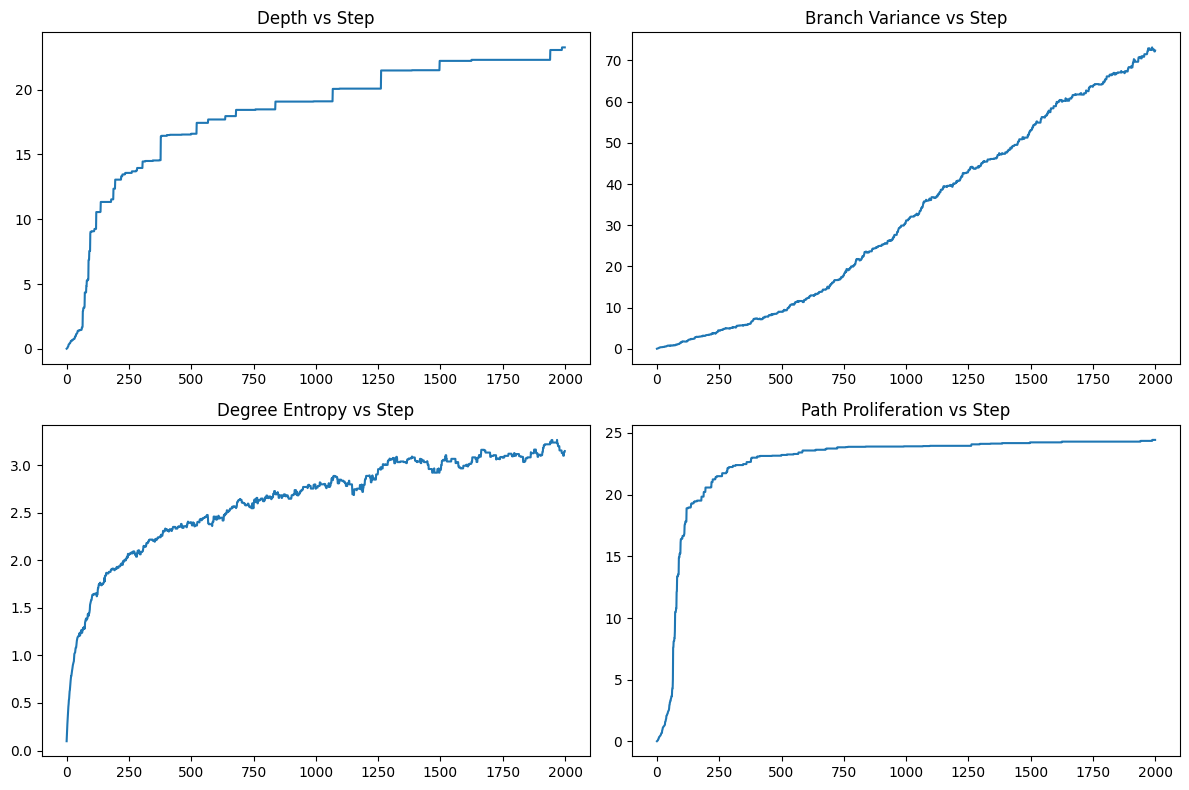

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(depth_hist)
plt.title("Depth vs Step")

plt.subplot(2,2,2)
plt.plot(branch_hist)
plt.title("Branch Variance vs Step")

plt.subplot(2,2,3)
plt.plot(entropy_hist)
plt.title("Degree Entropy vs Step")

plt.subplot(2,2,4)
plt.plot(path_hist)
plt.title("Path Proliferation vs Step")

plt.tight_layout()
plt.show()

In [15]:
couplings = [0.0, 0.5, 1.0, 5.0, 10.0]
steps = 2000
seed = 42

for coupling in couplings:
    results = run_simulation(steps=steps, coupling=coupling, seed=seed)
    G_final = results["graph_history"][-1]

    depth = compute_depth_complexity(G_final)
    branch = compute_branching_variance(G_final)
    entropy = compute_degree_entropy(G_final)
    path = compute_path_proliferation(G_final)

    print(f"Coupling {coupling}")
    print("Depth:", depth)
    print("Branch Var:", branch)
    print("Entropy:", entropy)
    print("Path:", path)
    print("-----")

Coupling 0.0
Depth: 23.26
Branch Var: 72.39039999999999
Entropy: 3.149290086117639
Path: 24.44
-----
Coupling 0.5
Depth: 22.98
Branch Var: 46.64639999999999
Entropy: 3.005607219225336
Path: 24.42
-----
Coupling 1.0
Depth: 24.04
Branch Var: 30.633599999999998
Entropy: 2.7609056855839897
Path: 24.48
-----
Coupling 5.0
Depth: 23.16
Branch Var: 6.7956
Entropy: 2.2145683319966887
Path: 24.4
-----
Coupling 10.0
Depth: 20.02
Branch Var: 2.6175999999999995
Entropy: 1.809503087845675
Path: 24.06
-----


In [16]:
import numpy as np

couplings = [0.0, 0.5, 1.0, 2.0, 5.0, 10.0]
steps = 2000
seeds = 10

summary = []

for coupling in couplings:
    depth_vals = []
    branch_vals = []
    entropy_vals = []
    path_vals = []

    for seed in range(seeds):
        results = run_simulation(steps=steps, coupling=coupling, seed=seed)
        G_final = results["graph_history"][-1]

        depth_vals.append(compute_depth_complexity(G_final))
        branch_vals.append(compute_branching_variance(G_final))
        entropy_vals.append(compute_degree_entropy(G_final))
        path_vals.append(compute_path_proliferation(G_final))

    summary.append({
        "coupling": coupling,
        "depth_mean": float(np.mean(depth_vals)),
        "depth_std": float(np.std(depth_vals)),
        "branch_mean": float(np.mean(branch_vals)),
        "branch_std": float(np.std(branch_vals)),
        "entropy_mean": float(np.mean(entropy_vals)),
        "entropy_std": float(np.std(entropy_vals)),
        "path_mean": float(np.mean(path_vals)),
        "path_std": float(np.std(path_vals)),
    })

summary

[{'coupling': 0.0,
  'depth_mean': 22.754,
  'depth_std': 1.1424902625405604,
  'branch_mean': 73.90572,
  'branch_std': 6.510979839133275,
  'entropy_mean': 3.1471302708664295,
  'entropy_std': 0.05634834816293248,
  'path_mean': 24.410000000000004,
  'path_std': 0.06942621983083908},
 {'coupling': 0.5,
  'depth_mean': 23.131999999999998,
  'depth_std': 1.0642631253595138,
  'branch_mean': 45.64672,
  'branch_std': 2.141569030780935,
  'entropy_mean': 3.0388066636298805,
  'entropy_std': 0.02898164785137253,
  'path_mean': 24.426000000000002,
  'path_std': 0.051419840528730214},
 {'coupling': 1.0,
  'depth_mean': 23.218000000000004,
  'depth_std': 0.47593697061690915,
  'branch_mean': 31.31076,
  'branch_std': 2.4569608703436843,
  'entropy_mean': 2.8517334492678765,
  'entropy_std': 0.0705123917336575,
  'path_mean': 24.41,
  'path_std': 0.06148170459575761},
 {'coupling': 2.0,
  'depth_mean': 22.726,
  'depth_std': 0.8530439613525206,
  'branch_mean': 17.6452,
  'branch_std': 1.6055

In [17]:
import numpy as np

coupling = np.array([s["coupling"] for s in summary], dtype=float)
branch   = np.array([s["branch_mean"] for s in summary], dtype=float)

# --- Fit log-log power law on coupling>0 (no offset) ---
mask = coupling > 0
x = np.log(coupling[mask])
y = np.log(branch[mask])

p, logA = np.polyfit(x, y, 1)          # y ≈ p x + logA
A = np.exp(logA)

# R^2
yhat = p*x + logA
r2 = 1 - np.sum((y-yhat)**2)/np.sum((y-np.mean(y))**2)

print("Power-law fit: branch ≈ A * coupling^p")
print("A =", A)
print("p =", p)
print("R^2 =", r2)

# --- Fit exponential: branch ≈ A exp(-k*coupling) + B (take B=0 first) ---
# Linearize: log(branch) ≈ logA - k*coupling
x2 = coupling[mask]
y2 = np.log(branch[mask])
m, b = np.polyfit(x2, y2, 1)           # y2 ≈ m x2 + b
k = -m
A2 = np.exp(b)
y2hat = m*x2 + b
r2exp = 1 - np.sum((y2-y2hat)**2)/np.sum((y2-np.mean(y2))**2)

print("\nExponential fit: branch ≈ A exp(-k*coupling)")
print("A =", A2)
print("k =", k)
print("R^2 =", r2exp)

Power-law fit: branch ≈ A * coupling^p
A = 28.351125420248884
p = -0.9696461212878478
R^2 = 0.9791925170123422

Exponential fit: branch ≈ A exp(-k*coupling)
A = 39.01517506301983
k = 0.291335009351235
R^2 = 0.9431127316954319


In [18]:
import numpy as np

couplings = [0.0, 0.5, 1.0, 2.0, 5.0, 10.0]
seeds = 10
step_list = [2000, 5000, 10000]

def fit_powerlaw(coupling_vals, y_vals):
    coupling_vals = np.array(coupling_vals, dtype=float)
    y_vals = np.array(y_vals, dtype=float)
    mask = coupling_vals > 0
    x = np.log(coupling_vals[mask])
    y = np.log(y_vals[mask])
    p, logA = np.polyfit(x, y, 1)
    yhat = p*x + logA
    r2 = 1 - np.sum((y-yhat)**2)/np.sum((y-np.mean(y))**2)
    A = float(np.exp(logA))
    return float(A), float(p), float(r2)

results_scaling = []

for steps in step_list:
    branch_means = []
    branch_stds = []

    for coupling in couplings:
        vals = []
        for seed in range(seeds):
            res = run_simulation(steps=steps, coupling=coupling, seed=seed)
            G_final = res["graph_history"][-1]
            vals.append(compute_branching_variance(G_final))
        branch_means.append(np.mean(vals))
        branch_stds.append(np.std(vals))

    A, p, r2 = fit_powerlaw(couplings, branch_means)
    results_scaling.append({
        "steps": steps,
        "A": A,
        "p": p,
        "R2": r2,
        "branch_means": branch_means,
        "branch_stds": branch_stds
    })

for r in results_scaling:
    print(f"\nSteps = {r['steps']}")
    print(f"Power law: branch ≈ {r['A']:.3f} * coupling^{r['p']:.3f}   (R^2={r['R2']:.4f})")


Steps = 2000
Power law: branch ≈ 28.351 * coupling^-0.970   (R^2=0.9792)

Steps = 5000
Power law: branch ≈ 54.667 * coupling^-1.117   (R^2=0.9853)

Steps = 10000
Power law: branch ≈ 76.710 * coupling^-1.183   (R^2=0.9858)
